In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import os
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import glob as gb
import cv2
import keras
from keras.applications import imagenet_utils

from keras import backend as K
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Dropout, Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle
import itertools 

#Model Graphs
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
!pip install split-folders

In [3]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/kaggle/input/plantvillage-dataset/color/", output="./new",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 54305 files [04:39, 194.08 files/s]


In [4]:
train_path='/kaggle/working/new/train/'
test_path='/kaggle/working/new/test/'
val_path='/kaggle/working/new/val/'

In [5]:
traingen = tf.keras.preprocessing.image.ImageDataGenerator()
testgen = tf.keras.preprocessing.image.ImageDataGenerator()
validgen =tf.keras.preprocessing.image.ImageDataGenerator()

In [6]:
train_ds=traingen.flow_from_directory(batch_size=64,directory=train_path,shuffle=True,
                                                 target_size=(128, 128),class_mode='categorical')
test_ds=traingen.flow_from_directory(batch_size=64,directory=test_path,shuffle=False,target_size=(128, 128), 
                                                 class_mode='categorical')

val_ds=traingen.flow_from_directory(batch_size=64,directory=val_path,shuffle=True,target_size=(128, 128), 
                                                 class_mode='categorical')

Found 43429 images belonging to 38 classes.
Found 5459 images belonging to 38 classes.
Found 5417 images belonging to 38 classes.


In [7]:
patch_size = 4  
image_size = 128
expansion_factor = 2  

In [8]:
def conv_block(x, filters=16, kernel_size=3, strides=2):
    conv_layer = layers.Conv2D(
        filters, kernel_size, strides=strides, activation=tf.nn.swish, padding="same"
    )
    return conv_layer(x)


# Reference: https://git.io/JKgtC


def inverted_residual_block(x, expanded_channels, output_channels, strides=1):
    m = layers.Conv2D(expanded_channels, 1, padding="same", use_bias=False)(x)
    m = layers.BatchNormalization()(m)
    m = tf.nn.swish(m)

    if strides == 2:
        m = layers.ZeroPadding2D(padding=imagenet_utils.correct_pad(m, 3))(m)
    m = layers.DepthwiseConv2D(
        3, strides=strides, padding="same" if strides == 1 else "valid", use_bias=False
    )(m)
    m = layers.BatchNormalization()(m)
    m = tf.nn.swish(m)

    m = layers.Conv2D(output_channels, 1, padding="same", use_bias=False)(m)
    m = layers.BatchNormalization()(m)

    if tf.math.equal(x.shape[-1], output_channels) and strides == 1:
        return layers.Add()([m, x])
    return m


# Reference:
# https://keras.io/examples/vision/image_classification_with_vision_transformer/


def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.swish)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


def transformer_block(x, transformer_layers, projection_dim, num_heads=2):
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=[x.shape[-1] * 2, x.shape[-1]], dropout_rate=0.1,)
        # Skip connection 2.
        x = layers.Add()([x3, x2])

    return x


def mobilevit_block(x, num_blocks, projection_dim, strides=1):
    # Local projection with convolutions.
    local_features = conv_block(x, filters=projection_dim, strides=strides)
    local_features = conv_block(
        local_features, filters=projection_dim, kernel_size=1, strides=strides
    )

    # Unfold into patches and then pass through Transformers.
    num_patches = int((local_features.shape[1] * local_features.shape[2]) / patch_size)
    non_overlapping_patches = layers.Reshape((patch_size, num_patches, projection_dim))(
        local_features
    )
    global_features = transformer_block(
        non_overlapping_patches, num_blocks, projection_dim
    )

    # Fold into conv-like feature-maps.
    folded_feature_map = layers.Reshape((*local_features.shape[1:-1], projection_dim))(
        global_features
    )

    # Apply point-wise conv -> concatenate with the input features.
    folded_feature_map = conv_block(
        folded_feature_map, filters=x.shape[-1], kernel_size=1, strides=strides
    )
    local_global_features = layers.Concatenate(axis=-1)([x, folded_feature_map])

    # Fuse the local and global features using a convoluion layer.
    local_global_features = conv_block(
        local_global_features, filters=projection_dim, strides=strides
    )

    return local_global_features

In [9]:
def create_mobilevit(num_classes=38):
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Initial conv-stem -> MV2 block.
    x = conv_block(x, filters=16)
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=16
    )

    # Downsampling with MV2 block.
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=24, strides=2
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )

    # First MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=48, strides=2
    )
    x = mobilevit_block(x, num_blocks=2, projection_dim=64)

    # Second MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=64 * expansion_factor, output_channels=64, strides=2
    )
    x = mobilevit_block(x, num_blocks=4, projection_dim=80)

    # Third MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=80 * expansion_factor, output_channels=80, strides=2
    )
    x = mobilevit_block(x, num_blocks=3, projection_dim=96)
    x = conv_block(x, filters=320, kernel_size=1, strides=1)

    # Classification head.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)


model = create_mobilevit()
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   448         rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   512         conv2d[0][0]                     
______________________________________________________________________________________________

In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [11]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(),optimizer='adam',
    metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")],
)

In [12]:
history = model.fit(train_ds, steps_per_epoch=len(train_ds),validation_data=val_ds, 
                    validation_steps=len(val_ds),epochs=50,callbacks=[callback],
                    verbose=1 )

Epoch 1/50
679/679 [==============================] - 132s 167ms/step - loss: 1.1580 - accuracy: 0.6603 - val_loss: 1.3404 - val_accuracy: 0.6264
Epoch 2/50
679/679 [==============================] - 112s 165ms/step - loss: 0.3684 - accuracy: 0.8783 - val_loss: 0.8485 - val_accuracy: 0.7633
Epoch 3/50
679/679 [==============================] - 112s 165ms/step - loss: 0.2195 - accuracy: 0.9278 - val_loss: 0.4876 - val_accuracy: 0.8529
Epoch 4/50
679/679 [==============================] - 114s 167ms/step - loss: 0.1641 - accuracy: 0.9460 - val_loss: 0.5077 - val_accuracy: 0.8732
Epoch 5/50
679/679 [==============================] - 112s 165ms/step - loss: 0.1251 - accuracy: 0.9578 - val_loss: 0.8413 - val_accuracy: 0.7955
Epoch 6/50
679/679 [==============================] - 113s 167ms/step - loss: 0.1165 - accuracy: 0.9605 - val_loss: 0.6363 - val_accuracy: 0.8381
Epoch 7/50
679/679 [==============================] - 113s 167ms/step - loss: 0.0948 - accuracy: 0.9677 - val_loss: 0.2975 -

In [13]:
from tensorflow.keras.utils import to_categorical
y_pred = model.predict_generator(test_ds)
y_pred2= to_categorical(np.argmax(y_pred, axis=1), 38)

y_test= to_categorical(test_ds.labels, 38)

# Using it in AUC
y_pred1=(np.argmax(y_pred, axis=1))
y_test1=(np.argmax(y_test, axis=1))

In [14]:
# Computing the Accuracy Score  : ((TP + TN) / float(TP + TN + FP + FN))
def Accuracy(y_test , y_pred):
    AccScore = accuracy_score(y_test, y_pred, normalize=True)
    return AccScore

In [15]:
#Computing the Precision metric (Some times called Specificity): #(True Positives / float(True Positives + False Posivites))  
def macro_precision(y_test , y_pred):
    PrecisionScore = precision_score(y_test, y_pred, average='macro') 
    return PrecisionScore

In [16]:
#Computing the Recall Score : (Some times called Sensitivity) (TP / float(TP + FN))   1 / 1+2  
def macro_recall(y_test , y_pred):
    RecallScore = recall_score(y_test, y_pred, average='macro') 
    return  RecallScore

In [17]:
#Computing the F1 Score  : 2 * (precision * recall) / (precision + recall)
def macro_F1Score(y_test , y_pred):
    F1Score = f1_score(y_test, y_pred, average='macro') 
    return F1Score

In [18]:
from sklearn.metrics import roc_auc_score

# Calculating Area under the curve
def AUC(actual_class, pred_class, average = "micro"):
    
    #Making a set of all the unique classes 
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #Making a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #Making the current class with label 1 and all other classes as a label 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        # Calculating the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [19]:
print("***** Model Evaluations Details ******** \n")
print("Test loss, Test acc : " , model.evaluate_generator(test_ds)) 
print("******************************")
print("Accurayc  : " , Accuracy(test_ds.classes , y_pred1)) 
print("******************************")
print("Precision Score is : " , macro_precision(test_ds.classes , y_pred1))
print("******************************")
print("Recall Scores is : " , macro_recall(test_ds.classes , y_pred1))
print("******************************")
print('F1 Score is : ', macro_F1Score(test_ds.classes , y_pred1))
print("******************************")
print('AUC Score is : ' , AUC(test_ds.classes, y_pred1))

***** Model Evaluations Details ******** 

Test loss, Test acc :  [0.24182839691638947, 0.9441289901733398]
******************************
Accurayc  :  0.9441289613482323
******************************
Precision Score is :  0.921829417310498
******************************
Recall Scores is :  0.9334441930372471
******************************
F1 Score is :  0.9189870065395243
******************************
AUC Score is :  {0: 0.9806985185969619, 1: 0.9837563392048196, 2: 0.9638253939027277, 3: 0.9693191835239436, 4: 0.9949931878409198, 5: 0.9810386699047263, 6: 0.976651128164509, 7: 0.8552143944459462, 8: 1.0, 9: 0.9925241218151668, 10: 0.9914529914529915, 11: 0.9946393267305368, 12: 0.9961209228106237, 13: 0.9907322301294693, 14: 0.9883720930232558, 15: 0.9983809361367818, 16: 0.9857696817337215, 17: 0.9861111111111112, 18: 0.9594628555800708, 19: 0.9261744966442953, 20: 0.8999066990110095, 21: 0.9829473782422093, 22: 0.99678486128973, 23: 0.9997232982844494, 24: 0.9692451032922547, 25:

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
plt.style.library['seaborn-whitegrid']

RcParams({'axes.axisbelow': True,
          'axes.edgecolor': '.8',
          'axes.facecolor': 'white',
          'axes.grid': True,
          'axes.labelcolor': '.15',
          'axes.linewidth': 1.0,
          'figure.facecolor': 'white',
          'font.family': ['sans-serif'],
          'font.sans-serif': ['Arial',
                              'Liberation Sans',
                              'DejaVu Sans',
                              'Bitstream Vera Sans',
                              'sans-serif'],
          'grid.color': '.8',
          'grid.linestyle': '-',
          'image.cmap': 'Greys',
          'legend.frameon': False,
          'legend.numpoints': 1,
          'legend.scatterpoints': 1,
          'lines.solid_capstyle': <CapStyle.round: 'round'>,
          'text.color': '.15',
          'xtick.color': '.15',
          'xtick.direction': 'out',
          'xtick.major.size': 0.0,
          'xtick.minor.size': 0.0,
          'ytick.color': '.15',
          'ytick.direct

In [21]:
def plot_roc_curve(y_test,y_pred):
    n_classes=38
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw=2
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
    plt.figure(figsize=(10, 10))
    plt.plot(fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,)

    plt.plot(fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)
    colors = cycle(["aqua", "darkorange", "cornflowerblue",'#9e9e9e','#b19a7e','#CD5C5C','#DFFF00',
                   '#DE3163','#ff4d4d','#CCCCFF','#800080','#4F1D25','#ccffcc','#ff0040'
                   ,'#4000ff','#0080ff','#ff8000','#666600','#b37700','#00b3b3','#003300','#FFC300','#A6F7BD',
                   '#A6BDF7','#CAA6F7','#F7A6AC','#ADF7A6','#F5F7A6','#F7CCA6','#EE4949',
                    '#DEA41F','#334471','#33716F','#343371','#772CE3','#B8BF20','#666B01','#0B6B01',
                    '#F4B708','#179690'
                   ])

    for i, color in zip(range(n_classes), colors):
        plt.plot(
           fpr[i],
           tpr[i],
           color=color,
           lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("MobileVit Roc Curve")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

In [22]:
def Acc_Loss_Graph(history):
    # converting hsitory to dataframe
    pd.DataFrame(history.history)

    pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')

    pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

In [23]:
labels=np.array(["Class 0","Class 1","Class 2","Class 3","Class 4","Class 5","Class 6","Class 7","Class 8","Class 9","Class 10","Class 11","Class 12","Class 13","Class 14","Class 15","Class 16","Class 17",
                "Class 18","Class 19","Class 20","Class 21","Class 22","Class 23","Class 24","Class 25","Class 26","Class 27","Class 28","Class 29","Class 30","Class 31","Class 32","Class 33","Class 34"
                ,"Class 35","Class 36","Class 37"])

In [24]:
def Confusion_Matrix(y_test , y_pred):
    fig, ax = plt.subplots(figsize=(20,20))

    #cnf_matrix = confusion_matrix()
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,display_labels=labels,ax=ax,xticks_rotation='vertical'
                                                  ,cmap="Blues")

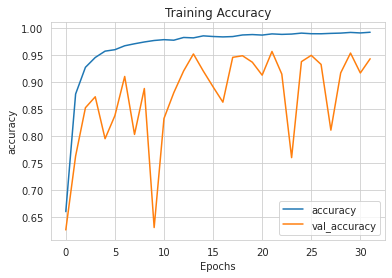

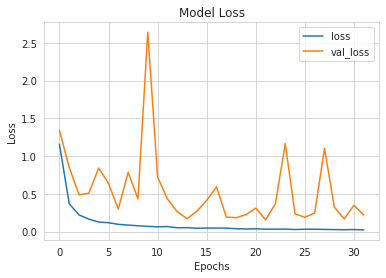

In [25]:
Acc_Loss_Graph(history)

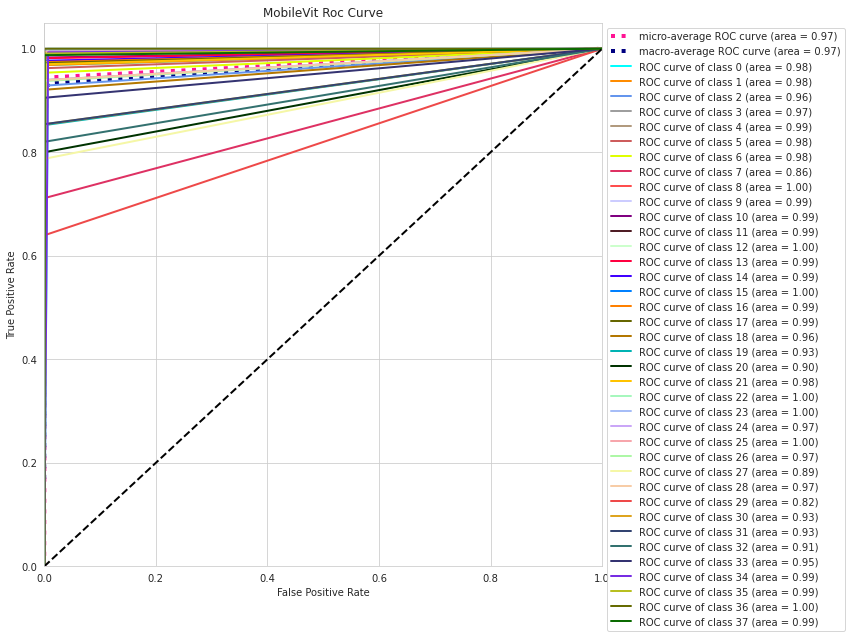

In [26]:
plot_roc_curve(y_test,y_pred2)

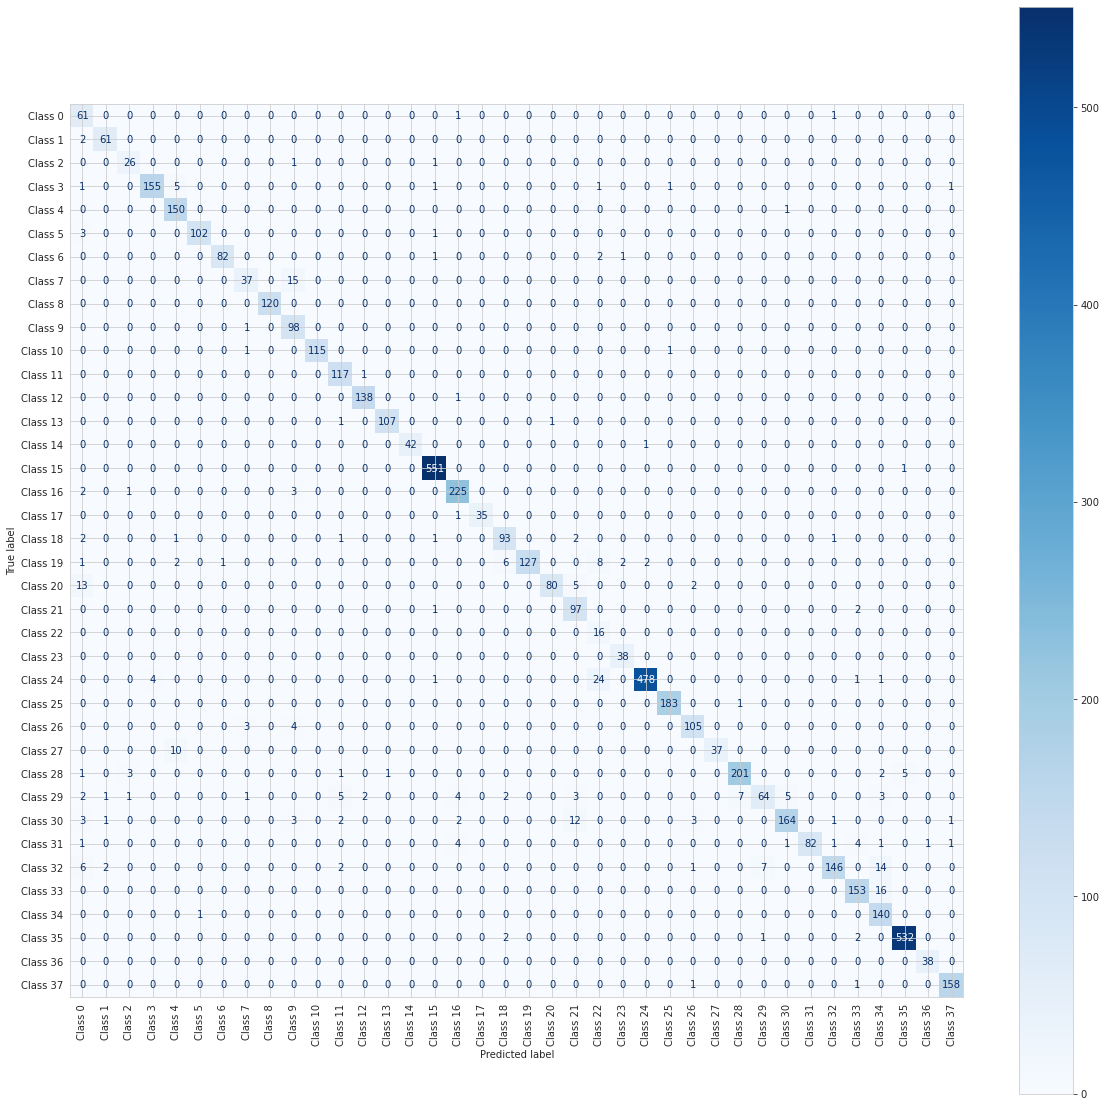

In [27]:
Confusion_Matrix(test_ds.classes , y_pred1)

In [28]:
target_name={0:"Class 0",1:"Class 1",2:"Class 2",3:"Class 3",4:"Class 4",5:"Class 5",6:"Class 6",7:"Class 7",8:"Class 8",9:"Class 9",
             10:"Class 10",11:"Class 11",12:"Class 12",
               13:"Class 13",14:"Class 14",15:"Class 15",16:"Class 16",17:"Class 17",18:"Class 18",19:"Class 19",20:"Class 20",21:"Class 21",
             22:"Class 22",23:"Class 23",24:"Class 24",25:"Class 25",26:"Class 26",27:"Class 27",28:"Class 28",29:"Class 29",30:"Class 30",31:"Class 31",32:"Class 32",33:"Class 33",34:"Class 34"
                ,35:"Class 35",36:"Class 36",37:"Class 37"}

In [29]:
from sklearn.manifold import TSNE
tsne1 = TSNE(random_state = 42, n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(y_pred)

In [30]:
# create dataframe
cps_df = pd.DataFrame(columns=['CP1', 'CP2', 'target'],
                       data=np.column_stack((tsne1, 
                                            y_test1)))# cast targets column to int
cps_df.loc[:, 'target'] = cps_df.target.astype(int)
cps_df.loc[:, 'target'] = cps_df.target.map(target_name)

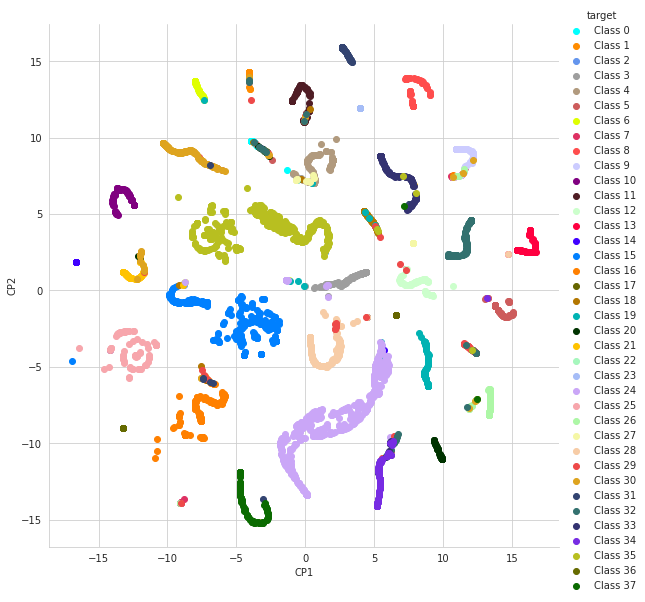

In [31]:
import seaborn as sns
d = {'color': ["aqua", "darkorange", "cornflowerblue",'#9e9e9e','#b19a7e','#CD5C5C','#DFFF00',
                   '#DE3163','#ff4d4d','#CCCCFF','#800080','#4F1D25','#ccffcc','#ff0040'
                   ,'#4000ff','#0080ff','#ff8000','#666600','#b37700','#00b3b3','#003300','#FFC300','#A6F7BD',
                   '#A6BDF7','#CAA6F7','#F7A6AC','#ADF7A6','#F5F7A6','#F7CCA6','#EE4949',
                    '#DEA41F','#334471','#33716F','#343371','#772CE3','#B8BF20','#666B01','#0B6B01',
                    '#F4B708','#179690'] }
grid = sns.FacetGrid(cps_df, hue="target",hue_kws=d, height=8)
grid.map(plt.scatter, 'CP1', 'CP2').add_legend()

In [32]:
model.save_weights('/kaggle/working/model1.h5')